In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import ViTForImageClassification
from tqdm import tqdm
import numpy as np
print(np.__version__)


1.23.0


In [3]:
data_dir = "C:\\Users\\hp\\Desktop\\project_folder"  # Directory where 'cracked' and 'uncracked' folders are located
batch_size = 16    # Number of images per batch during training
num_epochs = 5     # Number of times to iterate over the entire dataset


In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.ToTensor()           # Convert images to PyTorch tensors
])


In [7]:
# Load dataset
train_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Create a DataLoader for batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
print("Loaded...")


Loaded...


In [9]:
# Load the ViT model pre-trained on ImageNet, configured for binary classification
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=2)



C:\Users\hp\anaconda3\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not ini

In [11]:
criterion = nn.CrossEntropyLoss()                # Loss function
optimizer = optim.AdamW(model.parameters(), lr=1e-4)  # Optimizer
print("done...")

done...


In [19]:
# Loop over epochs
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Loop over each batch of images and labels
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):

        # Forward pass: calculate outputs by passing images through the model
        outputs = model(pixel_values=images).logits

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Compute gradients
        optimizer.step()       # Update weights

        # Update metrics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)  # Get class predictions
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    # Calculate and print epoch loss and accuracy
    epoch_loss = running_loss / total
    accuracy = correct / total * 100
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete!")


Epoch 1/5: 100%|███████████████████████████████████████████████████████████████████████| 90/90 [21:12<00:00, 14.14s/it]


Epoch [1/5], Loss: 0.1112, Accuracy: 97.22%


Epoch 2/5: 100%|███████████████████████████████████████████████████████████████████████| 90/90 [21:18<00:00, 14.20s/it]


Epoch [2/5], Loss: 0.0125, Accuracy: 99.86%


Epoch 3/5: 100%|███████████████████████████████████████████████████████████████████████| 90/90 [21:04<00:00, 14.05s/it]


Epoch [3/5], Loss: 0.0298, Accuracy: 99.17%


Epoch 4/5: 100%|███████████████████████████████████████████████████████████████████████| 90/90 [21:08<00:00, 14.10s/it]


Epoch [4/5], Loss: 0.0488, Accuracy: 98.61%


Epoch 5/5: 100%|███████████████████████████████████████████████████████████████████████| 90/90 [20:36<00:00, 13.74s/it]

Epoch [5/5], Loss: 0.0103, Accuracy: 99.65%
Training complete!


In [21]:
# Define the path to the test dataset
test_data_dir = "C:\\Users\\hp\\Desktop\\test"

# Apply the same transformations as used for the training data
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Ensure the size matches the model input size
    transforms.ToTensor()
])

# Load the test dataset
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=test_transform)

# Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Accuracy: 0.8904
Precision: 0.9882
Recall: 0.7850
F1 Score: 0.8750


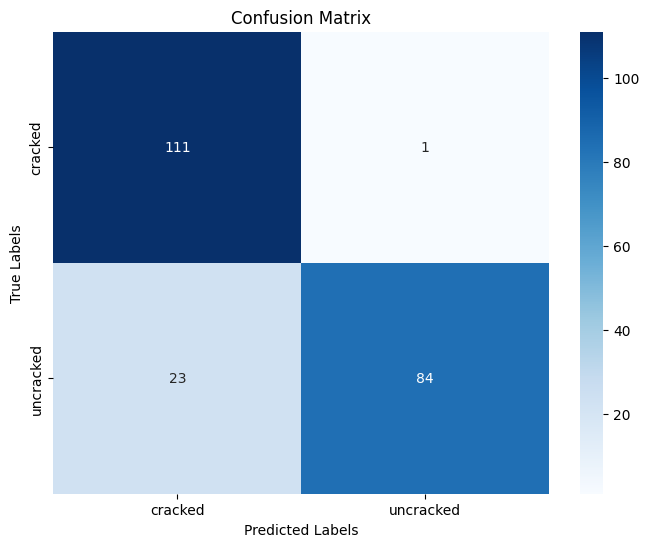

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, data_loader):
    model.eval()  # Set model to evaluation mode
    all_labels = []
    all_preds = []

    with torch.no_grad():  # Disable gradient calculations for faster computation
        for images, labels in data_loader:
            # Get model predictions
            outputs = model(pixel_values=images).logits
            _, preds = torch.max(outputs, 1)  # Get predicted class indices

            # Append predictions and labels for metric calculation
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    f1 = f1_score(all_labels, all_preds, average='binary')

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    class_names = ["cracked", "uncracked"]  # Replace with your actual class names if different

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

# Function to evaluate model accuracy, precision, recall, F1-score, and display the confusion matrix
evaluate_model(model, test_loader)


In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Sample code to compute and plot confusion matrix (replace y_true and y_pred with your actual values)
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Uncracked', 'Cracked'], yticklabels=['Uncracked', 'Cracked'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


NameError: name 'all_labels' is not defined